### Short visual of the model from, Alexander Kokhanovsky et al 2021

This method was used in our articles in IEEE and Cryosphere

In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
from scipy import interpolate


def art(ssa, c, lwc, cos_sza, cos_vza, theta, sensor_wavelengths, pollutant='Dust'):
    '''

    https://doi.org/10.3389/fenvs.2021.644551

    Retrieval of Dust Properties From Spectral Snow Reflectance Measurements
    adapted from Alexander Kokhanovsky et al 2021

    wavelengths [m]
    sza [rad]
    vza [rad]
    theta [deg]
    ssa [m2kg-1]
    c [ng g-1]
    lwc [percent of liquid water to mix in to the imag indic]
    g and b - shape of grain

    Soot, c is soot concentration (Bond 2006) in units of ng /g.
    Dust, c is dust concentration (Caponi 2017) in units of micro g / g. We assume MAE400=180 and aae=3.2

    '''

    # Adjust wavelengths
    wavelengths = sensor_wavelengths*1e-9


    # Ensure optimization stays in bounds
    if ssa<= 0.0 or c < 0.0 or lwc < 0.0 or cos_sza <= 0.0 :
        # This will give a very wild result but just scipy optimization will turn around
        # and keep within feasible range.
        warnings.warn('Warning...Optimization out of bounds, inserting dummy value.')
        ssa = 256
        c = 0.0
        lwc = 0.0
        theta = 0.0
        cos_sza = 1.0


    # Convert SSA
    d = 6 / (917*ssa)

    # Get ice and soot imag indices
    r_ice,k_ice = refice2016(wavelengths)

    # Set snow optical shapes
    g = 0.82 # Middle range of Robledano et al. 2023
    b = r_ice**2 #B=n2 from Robledano et al. 2023

    # Load in Segelstein 81 water data
    water_path = './data/segelstein81_index.csv'
    if not os.path.exists(water_path):
        water_path = '../data/segelstein81_index.csv'
    df_water = pd.read_csv(water_path)

    f_water_img = interpolate.interp1d(df_water['Wavelength'], df_water['Imaginary'], kind='slinear')
    k_water = f_water_img(wavelengths)
    
    # Composite refractive index
    k_eff = (1-lwc)*k_ice + lwc*k_water


    # r0 - semi-infinite non-absorbing snow layer
    p = 11.1 * np.exp(-0.087 * theta) + 1.1 * np.exp(-0.014 * theta)
    r0 = (1.247 + 1.186 * (cos_sza + cos_vza) + 5.157 * cos_sza * cos_vza + p) / 4.0 / (cos_sza + cos_vza)


    # Compute r - spherical albedo (considering different polutants)
    # Set pollutant constants
    if pollutant == 'Dust':
        aae = 3.2 # fixed based on PM2_5 China in Caponi 2017
        mae400 = 180 # fixed based on PM2_5 China in Caponi 2017
        mae = mae400 * (wavelengths / 400e-9)**(-aae)
        eps =  (9*(1-g)) / (16*b)
        beta = 2.0 / d * mae * c
        gamma_i = (4 * np.pi * k_eff) / wavelengths
        l =  d / eps
        r = np.exp(-np.sqrt(((gamma_i + beta) * l)))

    elif pollutant == 'Soot':
        #k_pollutant = 1.95 - 0.79j
        k_pollutant = 0.79
        pollutant_D=1.3
        eps =  (9*(1-g)) / (16*b)
        beta = (pollutant_D / b) * c
        gamma_i = (4 * np.pi * k_eff) / wavelengths
        gamma_p = (4 * np.pi * k_pollutant) / wavelengths
        l =  d / eps
        r = np.exp(-np.sqrt(((gamma_i + beta * gamma_p) * l)))

    else: #pollutant==None
        eps =  (9*(1-g)) / (16*b)
        gamma_i = (4 * np.pi * k_eff) / wavelengths
        l =  d / eps
        r = np.exp(-np.sqrt(((gamma_i) * l)))
    
 
    # Escape function - f
    u1 = 0.6*cos_sza + 1. / 3. + np.sqrt(cos_sza) / 3.
    u2 = 0.6*cos_vza + 1. / 3. + np.sqrt(cos_vza) / 3.
    f = (u1 * u2) / r0

    # Directional Reflectance (rho_s), r0 infinit factor, r spherical albedo, and escape function
    rho_s = r0 * r**f

    # Compute r_p - plane albedo
    r_p = r**u1

    return rho_s , r_p









################################
# BORROWED CODE HERE FROM TARTES
################################

def refice(wls, dataset_name):
    """return real and imag part of ice refractive index from the datset specified by dataset_name. wls in meter."""
    if dataset_name == "w2008":
        n, ni = refice2008(wls)
    elif dataset_name == "p2016":
        n, ni = refice2016(wls)
    else:
        raise Exception("Unknown refice '%s'" % refice)

    return n, ni

def refice2016(wls):
    """return real and imag part of ice refractive index. wls in meter"""
    refice2016_i = ki2016_clean_i/(4*np.pi)*(wls2016*1e-9)

    r2008 = refice2008(wls)
    r2016 = np.exp(np.interp(np.log(wls*1e9), np.log(wls2016), np.log(refice2016_i)))

    r = np.where(wls < 600e-9, r2016, r2008[1])
    return r2008[0], r

def refice2016_allsites(wls):
    """return real and imag part of ice refractive index. wls in meter"""
    refice2016_i = ki2016_allsites_i/(4*np.pi)*(wls2016*1e-9)

    r2008 = refice2008(wls)
    r2016 = np.exp(np.interp(np.log(wls*1e9), np.log(wls2016), np.log(refice2016_i)))

    r = np.where(wls < 600e-9, r2016, r2008[1])
    return r2008[0], r

def refice2008(wls):
    """return real and imag part of ice refractive index. wls in meter"""
    return np.interp(wls*1e9, wl2008, refice2008_r), np.exp(np.interp(np.log(wls*1e9), np.log(wl2008), np.log(refice2008_i)))


def refice1995(wls):
    """return real and imag part of ice refractive index. wls in meter"""
    return np.interp(wls*1e9, wl1995, refice1995_r), np.exp(np.interp(np.log(wls*1e9), np.log(wl1995), np.log(refice1995_i)))


def refsoot_imag(wavelengths):

    wl_um = 1e6*wavelengths

    index_soot_real = 1.811+0.1263*np.log(wl_um)+0.027*np.log(wl_um)**2+0.0417*np.log(wl_um)**3
    index_soot_im = 0.5821+0.1213*np.log(wl_um)+0.2309*np.log(wl_um)**2-0.01*np.log(wl_um)**3
    m_soot = index_soot_real - 1j*index_soot_im

    ######m_soot = 1.95- 1j*0.79
    temp = (m_soot**2-1)/(m_soot**2+2)
    return temp.imag

# wl in nm
wl2008 = 1000*np.array([
  1.990E-001, 2.010E-001, 2.019E-001, 2.100E-001, 2.500E-001, 3.000E-001, 3.500E-001, 3.900E-001, 4.000E-001, 4.100E-001, 4.200E-001, 4.300E-001, 4.400E-001, 4.500E-001, 4.600E-001, 4.700E-001, 4.800E-001, 4.900E-001, 5.000E-001, 5.100E-001, 5.200E-001, 5.300E-001, 5.400E-001, 5.500E-001, 5.600E-001, 5.700E-001, 5.800E-001, 5.900E-001, 6.000E-001, 6.100E-001, 6.200E-001, 6.300E-001, 6.400E-001, 6.500E-001, 6.600E-001, 6.700E-001, 6.800E-001, 6.900E-001, 7.000E-001, 7.100E-001, 7.200E-001, 7.300E-001, 7.400E-001, 7.500E-001, 7.600E-001, 7.700E-001, 7.800E-001, 7.900E-001, 8.000E-001, 8.100E-001, 8.200E-001, 8.300E-001, 8.400E-001, 8.500E-001, 8.600E-001, 8.700E-001, 8.800E-001, 8.900E-001, 9.000E-001, 9.100E-001, 9.200E-001, 9.300E-001, 9.400E-001, 9.500E-001, 9.600E-001, 9.700E-001, 9.800E-001, 9.900E-001, 1.000E+000, 1.010E+000, 1.020E+000, 1.030E+000, 1.040E+000, 1.050E+000, 1.060E+000, 1.070E+000, 1.080E+000, 1.090E+000, 1.100E+000, 1.110E+000, 1.120E+000, 1.130E+000, 1.140E+000, 1.150E+000, 1.160E+000, 1.170E+000, 1.180E+000, 1.190E+000, 1.200E+000, 1.210E+000, 1.220E+000, 1.230E+000, 1.240E+000, 1.250E+000, 1.260E+000, 1.270E+000, 1.280E+000, 1.290E+000, 1.300E+000, 1.310E+000, 1.320E+000, 1.330E+000, 1.340E+000, 1.350E+000, 1.360E+000, 1.370E+000, 1.380E+000, 1.390E+000, 1.400E+000, 1.410E+000, 1.420E+000, 1.430E+000, 1.440E+000, 1.449E+000, 1.460E+000, 1.471E+000, 1.481E+000, 1.493E+000, 1.504E+000, 1.515E+000, 1.527E+000, 1.538E+000, 1.563E+000, 1.587E+000, 1.613E+000, 1.650E+000, 1.680E+000, 1.700E+000, 1.730E+000, 1.760E+000, 1.800E+000, 1.830E+000, 1.840E+000, 1.850E+000, 1.855E+000, 1.860E+000, 1.870E+000, 1.890E+000, 1.905E+000, 1.923E+000, 1.942E+000, 1.961E+000, 1.980E+000, 2.000E+000, 2.020E+000, 2.041E+000, 2.062E+000, 2.083E+000, 2.105E+000, 2.130E+000, 2.150E+000, 2.170E+000, 2.190E+000, 2.220E+000, 2.240E+000, 2.245E+000, 2.250E+000, 2.260E+000, 2.270E+000, 2.290E+000, 2.310E+000, 2.330E+000, 2.350E+000, 2.370E+000, 2.390E+000, 2.410E+000, 2.430E+000, 2.460E+000, 2.500E+000, 2.520E+000, 2.550E+000, 2.565E+000, 2.580E+000, 2.590E+000, 2.600E+000, 2.620E+000, 2.675E+000, 2.725E+000, 2.778E+000, 2.817E+000, 2.833E+000, 2.849E+000, 2.865E+000, 2.882E+000, 2.899E+000, 2.915E+000, 2.933E+000, 2.950E+000, 2.967E+000, 2.985E+000, 3.003E+000])


refice2008_r = np.array([1.3943, 1.3914, 1.3901, 1.3801, 1.3509, 1.3339, 1.3249, 1.3203, 1.3194, 1.3185, 1.3177, 1.3170, 1.3163, 1.3157, 1.3151, 1.3145, 1.3140, 1.3135, 1.3130, 1.3126, 1.3121, 1.3117, 1.3114, 1.3110, 1.3106, 1.3103, 1.3100, 1.3097, 1.3094, 1.3091, 1.3088, 1.3085, 1.3083, 1.3080, 1.3078, 1.3076, 1.3073, 1.3071, 1.3069, 1.3067, 1.3065, 1.3062, 1.3060, 1.3059, 1.3057, 1.3055, 1.3053, 1.3051, 1.3049, 1.3047, 1.3046, 1.3044, 1.3042, 1.3040, 1.3039, 1.3037, 1.3035, 1.3033, 1.3032, 1.3030, 1.3028, 1.3027, 1.3025, 1.3023, 1.3022, 1.3020, 1.3019, 1.3017, 1.3015, 1.3014, 1.3012, 1.3010, 1.3009, 1.3007, 1.3005, 1.3003, 1.3002, 1.3000, 1.2998, 1.2997, 1.2995, 1.2993, 1.2991, 1.2990, 1.2988, 1.2986, 1.2984, 1.2982, 1.2980, 1.2979, 1.2977, 1.2975, 1.2973, 1.2971, 1.2969, 1.2967, 1.2965, 1.2963, 1.2961, 1.2959, 1.2957, 1.2955, 1.2953, 1.2951, 1.2949, 1.2946, 1.2944, 1.2941, 1.2939, 1.2937, 1.2934, 1.2931, 1.2929, 1.2927, 1.2924, 1.2921, 1.2920, 1.2918, 1.2916, 1.2914, 1.2912, 1.2909, 1.2903, 1.2897, 1.2890, 1.2879, 1.2870, 1.2863, 1.2853, 1.2843, 1.2828, 1.2816, 1.2811, 1.2807, 1.2805, 1.2802, 1.2797, 1.2788, 1.2780, 1.2771, 1.2762, 1.2756, 1.2750, 1.2744, 1.2736, 1.2728, 1.2718, 1.2707, 1.2694, 1.2677, 1.2663, 1.2648, 1.2633, 1.2609, 1.2591, 1.2587, 1.2582, 1.2573, 1.2564, 1.2545, 1.2525, 1.2504, 1.2482, 1.2459, 1.2435, 1.2409, 1.2382, 1.2337, 1.2270, 1.2232, 1.2169, 1.2135, 1.2097, 1.2071, 1.2043, 1.1983, 1.1776, 1.1507, 1.1083, 1.0657, 1.0453, 1.0236, 1.0001, 0.9747, 0.9563, 0.9538, 0.9678, 0.9873, 1.0026, 1.0180, 1.0390])


refice2008_i = np.array([9.565E-011, 3.249E-011, 2.0E-011, 2.0E-011, 2.0E-011, 2.0E-011, 2.0E-011, 2.0E-011, 2.365E-011, 2.669E-011, 3.135E-011, 4.140E-011, 6.268E-011, 9.239E-011, 1.325E-010, 1.956E-010, 2.861E-010, 4.172E-010, 5.889E-010, 8.036E-010, 1.076E-009, 1.409E-009, 1.813E-009, 2.289E-009, 2.839E-009, 3.461E-009, 4.159E-009, 4.930E-009, 5.730E-009, 6.890E-009, 8.580E-009, 1.040E-008, 1.220E-008, 1.430E-008, 1.660E-008, 1.890E-008, 2.090E-008, 2.400E-008, 2.900E-008, 3.440E-008, 4.030E-008, 4.300E-008, 4.920E-008, 5.870E-008, 7.080E-008, 8.580E-008, 1.020E-007, 1.180E-007, 1.340E-007, 1.400E-007, 1.430E-007, 1.450E-007, 1.510E-007, 1.830E-007, 2.150E-007, 2.650E-007, 3.350E-007, 3.920E-007, 4.200E-007, 4.440E-007, 4.740E-007, 5.110E-007, 5.530E-007, 6.020E-007, 7.550E-007, 9.260E-007, 1.120E-006, 1.330E-006, 1.620E-006, 2.000E-006, 2.250E-006, 2.330E-006, 2.330E-006, 2.170E-006, 1.960E-006, 1.810E-006, 1.740E-006, 1.730E-006, 1.700E-006, 1.760E-006, 1.820E-006, 2.040E-006, 2.250E-006, 2.290E-006, 3.040E-006, 3.840E-006, 4.770E-006, 5.760E-006, 6.710E-006, 8.660E-006, 1.020E-005, 1.130E-005, 1.220E-005, 1.290E-005, 1.320E-005, 1.350E-005, 1.330E-005, 1.320E-005, 1.320E-005, 1.310E-005, 1.320E-005, 1.320E-005, 1.340E-005, 1.390E-005, 1.420E-005, 1.480E-005, 1.580E-005, 1.740E-005, 1.980E-005, 3.442E-005, 5.959E-005, 1.028E-004, 1.516E-004, 2.030E-004, 2.942E-004, 3.987E-004, 4.941E-004, 5.532E-004, 5.373E-004, 5.143E-004, 4.908E-004, 4.594E-004, 3.858E-004, 3.105E-004, 2.659E-004, 2.361E-004, 2.046E-004, 1.875E-004, 1.650E-004, 1.522E-004, 1.411E-004, 1.302E-004, 1.310E-004, 1.339E-004, 1.377E-004, 1.432E-004, 1.632E-004, 2.566E-004, 4.081E-004, 7.060E-004, 1.108E-003, 1.442E-003, 1.614E-003, 1.640E-003, 1.566E-003, 1.458E-003, 1.267E-003, 1.023E-003, 7.586E-004, 5.255E-004, 4.025E-004, 3.235E-004, 2.707E-004, 2.228E-004, 2.037E-004, 2.026E-004, 2.035E-004, 2.078E-004, 2.171E-004, 2.538E-004, 3.138E-004, 3.858E-004, 4.591E-004, 5.187E-004, 5.605E-004, 5.956E-004, 6.259E-004, 6.820E-004, 7.530E-004, 7.685E-004, 7.647E-004, 7.473E-004, 7.392E-004, 7.437E-004, 7.543E-004, 8.059E-004, 1.367E-003, 3.508E-003, 1.346E-002, 3.245E-002, 4.572E-002, 6.287E-002, 8.548E-002, 1.198E-001, 1.690E-001, 2.210E-001, 2.760E-001, 3.120E-001, 3.470E-001, 3.880E-001, 4.380E-001])


wl1995 = 1000*np.array( [4.43000E-02, 4.51000E-02, 4.59000E-02, 4.68000E-02, 4.77000E-02, 4.86000E-02, 4.96000E-02, 5.06000E-02, 5.17000E-02, 5.28000E-02, 5.39000E-02, 5.51000E-02, 5.64000E-02, 5.77000E-02, 5.90000E-02, 6.05000E-02, 6.20000E-02, 6.36000E-02, 6.53000E-02, 6.70000E-02, 6.89000E-02, 7.08000E-02, 7.29000E-02, 7.38000E-02, 7.51000E-02, 7.75000E-02, 8.00000E-02, 8.27000E-02, 8.55000E-02, 8.86000E-02, 9.18000E-02, 9.30000E-02, 9.54000E-02, 9.92000E-02, 1.03300E-01, 1.07800E-01, 1.10000E-01, 1.12700E-01, 1.14000E-01, 1.18100E-01, 1.21000E-01, 1.24000E-01, 1.27200E-01, 1.29500E-01, 1.30500E-01, 1.31900E-01, 1.33300E-01, 1.34800E-01, 1.36200E-01, 1.37000E-01, 1.37800E-01, 1.38700E-01, 1.39300E-01, 1.40900E-01, 1.42500E-01, 1.43500E-01, 1.44200E-01, 1.45000E-01, 1.45900E-01, 1.46800E-01, 1.47600E-01, 1.48000E-01, 1.48500E-01, 1.49400E-01, 1.51200E-01, 1.53100E-01, 1.54000E-01, 1.55000E-01, 1.56900E-01, 1.58000E-01, 1.58900E-01, 1.61000E-01, 1.62700E-01, 1.65200E-01, 1.67500E-01, 1.70000E-01, 1.72300E-01, 1.74800E-01, 1.77100E-01, 1.79600E-01, 1.81000E-01, 1.82000E-01, 1.83000E-01, 1.84000E-01, 1.85000E-01, 1.88000E-01, 1.90000E-01, 1.95000E-01, 2.00000E-01, 2.05000E-01, 2.10000E-01, 2.15000E-01, 2.20000E-01, 2.25000E-01, 2.30000E-01, 2.35000E-01, 2.40000E-01, 2.45000E-01, 2.50000E-01, 2.60000E-01, 2.70000E-01, 2.80000E-01, 2.90000E-01, 3.00000E-01, 3.10000E-01, 3.20000E-01, 3.30000E-01, 3.40000E-01, 3.50000E-01, 3.60000E-01, 3.70000E-01, 3.80000E-01, 3.90000E-01, 4.00000E-01, 4.10000E-01, 4.20000E-01, 4.30000E-01, 4.40000E-01, 4.50000E-01, 4.60000E-01, 4.70000E-01, 4.80000E-01, 4.90000E-01, 5.00000E-01, 5.10000E-01, 5.20000E-01, 5.30000E-01, 5.40000E-01, 5.50000E-01, 5.60000E-01, 5.70000E-01, 5.80000E-01, 5.90000E-01, 6.00000E-01, 6.10000E-01, 6.20000E-01, 6.30000E-01, 6.40000E-01, 6.50000E-01, 6.60000E-01, 6.70000E-01, 6.80000E-01, 6.90000E-01, 7.00000E-01, 7.10000E-01, 7.20000E-01, 7.30000E-01, 7.40000E-01, 7.50000E-01, 7.60000E-01, 7.70000E-01, 7.80000E-01, 7.90000E-01, 8.00000E-01, 8.10000E-01, 8.20000E-01, 8.30000E-01, 8.40000E-01, 8.50000E-01, 8.60000E-01, 8.70000E-01, 8.80000E-01, 8.90000E-01, 9.00000E-01, 9.10000E-01, 9.20000E-01, 9.30000E-01, 9.40000E-01, 9.50000E-01, 9.60000E-01, 9.70000E-01, 9.80000E-01, 9.90000E-01, 1.00000, 1.01000, 1.02000, 1.03000, 1.04000, 1.05000, 1.06000, 1.07000, 1.08000, 1.09000, 1.10000, 1.11000, 1.12000, 1.13000, 1.14000, 1.15000, 1.16000, 1.17000, 1.18000, 1.19000, 1.20000, 1.21000, 1.22000, 1.23000, 1.24000, 1.25000, 1.26000, 1.27000, 1.28000, 1.29000, 1.30000, 1.31000, 1.32000, 1.33000, 1.34000, 1.35000, 1.36000, 1.37000, 1.38000, 1.39000, 1.40000, 1.41000, 1.42000, 1.43000, 1.44000, 1.44510, 1.44930, 1.45350, 1.45770, 1.46200, 1.46630, 1.47060, 1.47490, 1.47930, 1.48370, 1.48810, 1.49250, 1.49700, 1.50150, 1.50600, 1.51060, 1.51520, 1.51980, 1.52440, 1.52910, 1.53370, 1.53850, 1.54320, 1.54800, 1.55280, 1.55760, 1.56250, 1.56740, 1.57230, 1.57730, 1.58230, 1.58730, 1.59240, 1.59740, 1.60260, 1.60770, 1.61290, 1.61810, 1.62340, 1.62870, 1.63400, 1.63930, 1.64470, 1.65020, 1.65560, 1.66110, 1.66670, 1.67220, 1.67790, 1.68350, 1.68920, 1.69490, 1.70070, 1.70650, 1.71230, 1.71820, 1.72410, 1.73010, 1.73610, 1.74220, 1.74830, 1.75440, 1.76060, 1.76680, 1.77300, 1.77940, 1.78570, 1.79210, 1.79860, 1.80510, 1.81160, 1.81820, 1.82480, 1.83150, 1.83820, 1.84500, 1.85190, 1.85870, 1.86570, 1.87270, 1.87970, 1.88680, 1.89390, 1.90110, 1.90840, 1.91570, 1.92310, 1.93050, 1.93800, 1.94550, 1.95310, 1.96080, 1.96850, 1.97630, 1.98410, 1.99200, 2.00000, 2.00800, 2.01610, 2.02430, 2.03250, 2.04080, 2.04920, 2.05760, 2.06610, 2.07470, 2.08330, 2.09210, 2.10080, 2.10970, 2.11860, 2.12770, 2.13680, 2.14590, 2.15520, 2.16450, 2.17390, 2.18340, 2.19300, 2.20260, 2.21240, 2.22220, 2.23210, 2.24220, 2.25230, 2.26240, 2.27270, 2.28310, 2.29360, 2.30410, 2.31480, 2.32560, 2.33640, 2.34740, 2.35850, 2.36970, 2.38100, 2.39230, 2.40380, 2.41550, 2.42720, 2.43900, 2.45100, 2.46310, 2.47520, 2.48760, 2.50000, 2.52000, 2.55000, 2.56500, 2.58000, 2.59000, 2.60000, 2.62000, 2.67500, 2.72500, 2.77800, 2.81700, 2.83300, 2.84900, 2.86500, 2.88200, 2.89900, 2.91500, 2.93300, 2.95000, 2.96700, 2.98500, 3.00300, 3.02100, 3.04000, 3.05800, 3.07700, 3.09600, 3.11500, 3.13500, 3.15500, 3.17500, 3.19500, 3.21500, 3.23600, 3.25700, 3.27900, 3.30000, 3.32200, 3.34500, 3.36700, 3.39000, 3.41300, 3.43600, 3.46000, 3.48400, 3.50900, 3.53400, 3.55900, 3.62400, 3.73200, 3.77500, 3.84700, 3.96900, 4.09900, 4.23900, 4.34800, 4.38700, 4.44400, 4.50500, 4.54700, 4.56000, 4.58000, 4.71900, 4.90400, 5.00000, 5.10000, 5.20000, 5.26300, 5.40000, 5.55600, 5.71400, 5.74700, 5.78000, 5.81400, 5.84800, 5.88200, 6.06100, 6.13500, 6.25000, 6.28900, 6.32900, 6.36900, 6.41000, 6.45200, 6.49400, 6.57900, 6.66700, 6.75700, 6.89700, 7.04200, 7.14300, 7.24600, 7.35300, 7.46300, 7.57600, 7.69200, 7.81200, 7.93700, 8.06500, 8.19700, 8.33300, 8.47500, 8.69600, 8.92900, 9.09100, 9.25900, 9.52400, 9.80400, 1.00000E+01, 1.02000E+01, 1.03100E+01, 1.04200E+01, 1.05300E+01, 1.06400E+01, 1.07500E+01, 1.08700E+01, 1.10000E+01, 1.11100E+01, 1.13600E+01, 1.16300E+01, 1.19000E+01, 1.22000E+01, 1.25000E+01, 1.28200E+01, 1.29900E+01, 1.31600E+01, 1.33300E+01, 1.35100E+01, 1.37000E+01, 1.38900E+01, 1.40800E+01, 1.42900E+01, 1.47100E+01, 1.51500E+01, 1.53800E+01, 1.56300E+01, 1.61300E+01, 1.63900E+01, 1.66700E+01, 1.69500E+01, 1.72400E+01, 1.81800E+01, 1.88700E+01, 1.92300E+01, 1.96100E+01, 2.00000E+01, 2.04100E+01, 2.08300E+01, 2.22200E+01, 2.26000E+01, 2.30500E+01, 2.36000E+01, 2.46000E+01, 2.50000E+01, 2.60000E+01, 2.85700E+01, 3.10000E+01, 3.33300E+01, 3.44800E+01, 3.56400E+01, 3.70000E+01, 3.82400E+01, 3.96000E+01, 4.11400E+01, 4.27600E+01, 4.35800E+01, 4.45800E+01, 4.55000E+01, 4.61500E+01, 4.67100E+01, 4.73600E+01, 4.80000E+01, 4.87800E+01, 5.00300E+01, 5.12800E+01, 5.27500E+01, 5.35000E+01, 5.42400E+01, 5.50000E+01, 5.57400E+01, 5.64000E+01, 5.70000E+01, 5.74600E+01, 5.84000E+01, 5.92900E+01, 6.00000E+01, 6.10000E+01, 6.12500E+01, 6.25000E+01, 6.37800E+01, 6.46700E+01, 6.55800E+01, 6.65500E+01, 6.76000E+01, 6.90000E+01, 7.05300E+01, 7.30000E+01, 7.50000E+01, 7.62900E+01, 8.00000E+01, 8.29700E+01, 8.50000E+01, 8.68000E+01, 9.08000E+01, 9.51700E+01, 1.00000E+02, 1.20000E+02, 1.50000E+02, 1.67000E+02])

refice1995_r = np.array([8.34410E-01, 8.36760E-01, 8.37290E-01, 8.37710E-01, 8.38270E-01, 8.40380E-01, 8.47190E-01, 8.55220E-01, 8.60470E-01, 8.62480E-01, 8.61570E-01, 8.60930E-01, 8.64190E-01, 8.69160E-01, 8.77640E-01, 8.92960E-01, 9.10410E-01, 9.30890E-01, 9.53730E-01, 9.81880E-01, 1.02334, 1.06735, 1.11197, 1.13134, 1.15747, 1.20045, 1.23840, 1.27325, 1.32157, 1.38958, 1.41644, 1.40906, 1.40063, 1.40169, 1.40934, 1.40221, 1.39240, 1.38424, 1.38075, 1.38186, 1.39634, 1.40918, 1.40256, 1.38013, 1.36303, 1.34144, 1.32377, 1.30605, 1.29054, 1.28890, 1.28931, 1.30190, 1.32025, 1.36302, 1.41872, 1.45834, 1.49028, 1.52128, 1.55376, 1.57782, 1.59636, 1.60652, 1.61172, 1.61919, 1.62522, 1.63404, 1.63689, 1.63833, 1.63720, 1.63233, 1.62222, 1.58270, 1.55360, 1.52040, 1.49840, 1.48010, 1.46710, 1.45510, 1.44580, 1.43700, 1.43250, 1.42950, 1.42680, 1.42410, 1.42140, 1.41430, 1.41010, 1.40070, 1.39360, 1.38670, 1.38000, 1.37610, 1.37230, 1.36850, 1.36480, 1.36120, 1.35770, 1.35420, 1.35080, 1.34720, 1.34370, 1.34030, 1.33710, 1.33390, 1.33200, 1.33020, 1.32840, 1.32660, 1.32490, 1.32380, 1.32260, 1.32150, 1.32040, 1.31940, 1.31850, 1.31775, 1.31702, 1.31633, 1.31569, 1.31509, 1.31452, 1.31399, 1.31349, 1.31302, 1.31257, 1.31215, 1.31175, 1.31136, 1.31099, 1.31064, 1.31031, 1.30999, 1.30968, 1.30938, 1.30909, 1.30882, 1.30855, 1.30829, 1.30804, 1.30780, 1.30756, 1.30733, 1.30710, 1.30688, 1.30667, 1.30646, 1.30625, 1.30605, 1.30585, 1.30566, 1.30547, 1.30528, 1.30509, 1.30491, 1.30473, 1.30455, 1.30437, 1.30419, 1.30402, 1.30385, 1.30367, 1.30350, 1.30333, 1.30316, 1.30299, 1.30283, 1.30266, 1.30249, 1.30232, 1.30216, 1.30199, 1.30182, 1.30166, 1.30149, 1.30132, 1.30116, 1.30099, 1.30082, 1.30065, 1.30048, 1.30031, 1.30014, 1.29997, 1.29979, 1.29962, 1.29945, 1.29927, 1.29909, 1.29891, 1.29873, 1.29855, 1.29837, 1.29818, 1.29800, 1.29781, 1.29762, 1.29743, 1.29724, 1.29705, 1.29686, 1.29666, 1.29646, 1.29626, 1.29605, 1.29584, 1.29563, 1.29542, 1.29521, 1.29499, 1.29476, 1.29453, 1.29430, 1.29406, 1.29381, 1.29355, 1.29327, 1.29299, 1.29272, 1.29260, 1.29250, 1.29240, 1.29230, 1.29230, 1.29220, 1.29210, 1.29200, 1.29190, 1.29180, 1.29180, 1.29170, 1.29160, 1.29160, 1.29150, 1.29140, 1.29130, 1.29120, 1.29110, 1.29100, 1.29090, 1.29080, 1.29070, 1.29060, 1.29050, 1.29040, 1.29030, 1.29020, 1.29000, 1.28990, 1.28970, 1.28960, 1.28950, 1.28930, 1.28920, 1.28900, 1.28890, 1.28880, 1.28860, 1.28840, 1.28830, 1.28810, 1.28800, 1.28780, 1.28760, 1.28750, 1.28730, 1.28710, 1.28700, 1.28680, 1.28660, 1.28640, 1.28620, 1.28600, 1.28580, 1.28560, 1.28540, 1.28520, 1.28500, 1.28470, 1.28450, 1.28430, 1.28410, 1.28380, 1.28360, 1.28340, 1.28310, 1.28290, 1.28260, 1.28240, 1.28210, 1.28190, 1.28160, 1.28130, 1.28100, 1.28070, 1.28040, 1.28010, 1.27970, 1.27940, 1.27900, 1.27870, 1.27830, 1.27790, 1.27750, 1.27720, 1.27690, 1.27660, 1.27630, 1.27600, 1.27570, 1.27540, 1.27510, 1.27480, 1.27460, 1.27430, 1.27400, 1.27370, 1.27340, 1.27310, 1.27280, 1.27240, 1.27200, 1.27160, 1.27120, 1.27070, 1.27030, 1.26980, 1.26930, 1.26870, 1.26810, 1.26750, 1.26690, 1.26620, 1.26550, 1.26480, 1.26410, 1.26330, 1.26260, 1.26180, 1.26100, 1.26020, 1.25930, 1.25840, 1.25750, 1.25650, 1.25550, 1.25450, 1.25340, 1.25240, 1.25130, 1.25020, 1.24900, 1.24780, 1.24650, 1.24510, 1.24380, 1.24240, 1.24080, 1.23930, 1.23770, 1.23590, 1.23410, 1.23220, 1.23010, 1.22790, 1.22580, 1.22198, 1.21548, 1.21184, 1.20790, 1.20507, 1.20209, 1.19566, 1.17411, 1.14734, 1.10766, 1.06739, 1.04762, 1.02650, 1.00357, 9.81970E-01, 9.65030E-01, 9.59620E-01, 9.72690E-01, 9.91720E-01, 1.00668, 1.02186, 1.04270, 1.07597, 1.12954, 1.21267, 1.32509, 1.42599, 1.49656, 1.55095, 1.59988, 1.63631, 1.65024, 1.64278, 1.62691, 1.61284, 1.59245, 1.57329, 1.55770, 1.54129, 1.52654, 1.51139, 1.49725, 1.48453, 1.47209, 1.46125, 1.45132, 1.44215, 1.43366, 1.41553, 1.39417, 1.38732, 1.37735, 1.36448, 1.35414, 1.34456, 1.33882, 1.33807, 1.33847, 1.34053, 1.34287, 1.34418, 1.34634, 1.34422, 1.33453, 1.32897, 1.32333, 1.31800, 1.31432, 1.30623, 1.29722, 1.28898, 1.28730, 1.28603, 1.28509, 1.28535, 1.28813, 1.30156, 1.30901, 1.31720, 1.31893, 1.32039, 1.32201, 1.32239, 1.32149, 1.32036, 1.31814, 1.31705, 1.31807, 1.31953, 1.31933, 1.31896, 1.31909, 1.31796, 1.31631, 1.31542, 1.31540, 1.31552, 1.31455, 1.31193, 1.30677, 1.29934, 1.29253, 1.28389, 1.27401, 1.26724, 1.25990, 1.24510, 1.22241, 1.19913, 1.17150, 1.15528, 1.13700, 1.11808, 1.10134, 1.09083, 1.08734, 1.09254, 1.10654, 1.14779, 1.20202, 1.25825, 1.32305, 1.38574, 1.44478, 1.47170, 1.49619, 1.51652, 1.53328, 1.54900, 1.56276, 1.57317, 1.58028, 1.57918, 1.56672, 1.55869, 1.55081, 1.53807, 1.53296, 1.53220, 1.53340, 1.53289, 1.51705, 1.50097, 1.49681, 1.49928, 1.50153, 1.49856, 1.49053, 1.46070, 1.45182, 1.44223, 1.43158, 1.41385, 1.40676, 1.38955, 1.34894, 1.31039, 1.26420, 1.23656, 1.21663, 1.20233, 1.19640, 1.19969, 1.20860, 1.22173, 1.24166, 1.28175, 1.32784, 1.38657, 1.46486, 1.55323, 1.60379, 1.61877, 1.62963, 1.65712, 1.69810, 1.72065, 1.74865, 1.76736, 1.76476, 1.75011, 1.72327, 1.68490, 1.62398, 1.59596, 1.58514, 1.59917, 1.61405, 1.66625, 1.70663, 1.73713, 1.76860, 1.80343, 1.83296, 1.85682, 1.87411, 1.89110, 1.89918, 1.90432, 1.90329, 1.88744, 1.87499, 1.86702, 1.85361, 1.84250, 1.83225, 1.81914, 1.82268, 1.82961])

refice1995_i = np.array([1.64000E-01, 1.73000E-01, 1.83000E-01, 1.95000E-01, 2.08000E-01, 2.23000E-01, 2.40000E-01, 2.50000E-01, 2.59000E-01, 2.68000E-01, 2.79000E-01, 2.97000E-01, 3.19000E-01, 3.40000E-01, 3.66000E-01, 3.92000E-01, 4.16000E-01, 4.40000E-01, 4.64000E-01, 4.92000E-01, 5.17000E-01, 5.28000E-01, 5.33000E-01, 5.34000E-01, 5.31000E-01, 5.24000E-01, 5.10000E-01, 5.00000E-01, 4.99000E-01, 4.68000E-01, 3.80000E-01, 3.60000E-01, 3.39000E-01, 3.18000E-01, 2.91000E-01, 2.51000E-01, 2.44000E-01, 2.39000E-01, 2.39000E-01, 2.44000E-01, 2.47000E-01, 2.24000E-01, 1.95000E-01, 1.74000E-01, 1.72000E-01, 1.80000E-01, 1.94000E-01, 2.13000E-01, 2.43000E-01, 2.71000E-01, 2.89000E-01, 3.34000E-01, 3.44000E-01, 3.82000E-01, 4.01000E-01, 4.06500E-01, 4.05000E-01, 3.89000E-01, 3.77000E-01, 3.45000E-01, 3.32000E-01, 3.15000E-01, 2.98000E-01, 2.74000E-01, 2.28000E-01, 1.98000E-01, 1.72000E-01, 1.56000E-01, 1.10000E-01, 8.30000E-02, 5.80000E-02, 2.20000E-02, 1.00000E-02, 3.00000E-03, 1.00000E-03, 3.00000E-04, 1.00000E-04, 3.00000E-05, 1.00000E-05, 3.00000E-06, 1.56700E-06, 9.32500E-07, 5.39700E-07, 3.12200E-07, 1.72500E-07, 1.00000E-07, 8.20000E-08, 5.10000E-08, 3.81000E-08, 3.05000E-08, 2.51000E-08, 2.18000E-08, 1.98000E-08, 1.78000E-08, 1.62000E-08, 1.50000E-08, 1.43000E-08, 1.37000E-08, 1.33000E-08, 1.32000E-08, 1.30000E-08, 1.26000E-08, 1.18000E-08, 1.10000E-08, 9.28000E-09, 8.25000E-09, 7.65000E-09, 7.00000E-09, 6.15000E-09, 5.10000E-09, 4.13000E-09, 3.43000E-09, 3.12000E-09, 2.82000E-09, 2.51000E-09, 2.26000E-09, 2.08000E-09, 1.91000E-09, 1.54000E-09, 1.53000E-09, 1.55000E-09, 1.64000E-09, 1.78000E-09, 1.91000E-09, 2.14000E-09, 2.26000E-09, 2.54000E-09, 2.93000E-09, 3.11000E-09, 3.29000E-09, 3.52000E-09, 4.04000E-09, 4.88000E-09, 5.73000E-09, 6.89000E-09, 8.58000E-09, 1.04000E-08, 1.22000E-08, 1.43000E-08, 1.66000E-08, 1.89000E-08, 2.09000E-08, 2.40000E-08, 2.90000E-08, 3.44000E-08, 4.03000E-08, 4.30000E-08, 4.92000E-08, 5.87000E-08, 7.08000E-08, 8.58000E-08, 1.02000E-07, 1.18000E-07, 1.34000E-07, 1.40000E-07, 1.43000E-07, 1.45000E-07, 1.51000E-07, 1.83000E-07, 2.15000E-07, 2.65000E-07, 3.35000E-07, 3.92000E-07, 4.20000E-07, 4.44000E-07, 4.74000E-07, 5.11000E-07, 5.53000E-07, 6.02000E-07, 7.55000E-07, 9.26000E-07, 1.12000E-06, 1.33000E-06, 1.62000E-06, 2.00000E-06, 2.25000E-06, 2.33000E-06, 2.33000E-06, 2.17000E-06, 1.96000E-06, 1.81000E-06, 1.74000E-06, 1.73000E-06, 1.70000E-06, 1.76000E-06, 1.82000E-06, 2.04000E-06, 2.25000E-06, 2.29000E-06, 3.04000E-06, 3.84000E-06, 4.77000E-06, 5.76000E-06, 6.71000E-06, 8.66000E-06, 1.02000E-05, 1.13000E-05, 1.22000E-05, 1.29000E-05, 1.32000E-05, 1.35000E-05, 1.33000E-05, 1.32000E-05, 1.32000E-05, 1.31000E-05, 1.32000E-05, 1.32000E-05, 1.34000E-05, 1.39000E-05, 1.42000E-05, 1.48000E-05, 1.58000E-05, 1.74000E-05, 1.98000E-05, 2.50000E-05, 5.40000E-05, 9.00000E-05, 1.30000E-04, 1.60000E-04, 1.89000E-04, 2.20000E-04, 2.58000E-04, 2.99000E-04, 3.42000E-04, 3.86000E-04, 4.33000E-04, 4.71000E-04, 5.03000E-04, 5.27000E-04, 5.34000E-04, 5.38000E-04, 5.33000E-04, 5.27000E-04, 5.17000E-04, 5.09000E-04, 4.98000E-04, 4.87000E-04, 4.75000E-04, 4.62000E-04, 4.51000E-04, 4.37000E-04, 4.25000E-04, 4.08000E-04, 3.92000E-04, 3.75000E-04, 3.58000E-04, 3.42000E-04, 3.24000E-04, 3.11000E-04, 2.97000E-04, 2.84000E-04, 2.74000E-04, 2.66000E-04, 2.59000E-04, 2.53000E-04, 2.49000E-04, 2.47000E-04, 2.44000E-04, 2.40000E-04, 2.35000E-04, 2.29000E-04, 2.23000E-04, 2.16000E-04, 2.11000E-04, 2.05000E-04, 1.97000E-04, 1.92000E-04, 1.87000E-04, 1.82000E-04, 1.78000E-04, 1.72000E-04, 1.67000E-04, 1.63000E-04, 1.59000E-04, 1.54000E-04, 1.52000E-04, 1.49000E-04, 1.48000E-04, 1.45000E-04, 1.42000E-04, 1.40000E-04, 1.39000E-04, 1.38000E-04, 1.37000E-04, 1.35000E-04, 1.33000E-04, 1.31000E-04, 1.30000E-04, 1.28000E-04, 1.26000E-04, 1.25000E-04, 1.23000E-04, 1.23000E-04, 1.26000E-04, 1.26000E-04, 1.33000E-04, 1.42000E-04, 1.56000E-04, 1.87000E-04, 2.33000E-04, 2.98000E-04, 4.00000E-04, 4.84000E-04, 5.53000E-04, 6.82000E-04, 8.38000E-04, 9.91000E-04, 1.16000E-03, 1.31000E-03, 1.42000E-03, 1.52000E-03, 1.59000E-03, 1.63000E-03, 1.64000E-03, 1.64000E-03, 1.63000E-03, 1.59000E-03, 1.55000E-03, 1.52000E-03, 1.45000E-03, 1.40000E-03, 1.32000E-03, 1.23000E-03, 1.13000E-03, 1.02000E-03, 9.30000E-04, 8.20000E-04, 7.19000E-04, 6.28000E-04, 5.50000E-04, 4.85000E-04, 4.28000E-04, 3.83000E-04, 3.48000E-04, 3.17000E-04, 2.93000E-04, 2.71000E-04, 2.54000E-04, 2.38000E-04, 2.27000E-04, 2.17000E-04, 2.12000E-04, 2.10000E-04, 2.16000E-04, 2.28000E-04, 2.46000E-04, 2.72000E-04, 3.03000E-04, 3.40000E-04, 3.81000E-04, 4.20000E-04, 4.61000E-04, 4.97000E-04, 5.27000E-04, 5.54000E-04, 5.77000E-04, 5.99000E-04, 6.21000E-04, 6.40000E-04, 6.61000E-04, 6.91000E-04, 7.20000E-04, 7.44000E-04, 7.72000E-04, 8.04000E-04, 8.25500E-04, 8.57800E-04, 8.73900E-04, 8.90000E-04, 9.30000E-04, 1.01000E-03, 1.35000E-03, 3.42000E-03, 7.92000E-03, 2.00000E-02, 3.80000E-02, 5.20000E-02, 6.80000E-02, 9.23000E-02, 1.27000E-01, 1.69000E-01, 2.21000E-01, 2.76000E-01, 3.12000E-01, 3.47000E-01, 3.88000E-01, 4.38000E-01, 4.93000E-01, 5.54000E-01, 6.12000E-01, 6.25000E-01, 5.93000E-01, 5.39000E-01, 4.91000E-01, 4.38000E-01, 3.72000E-01, 3.00000E-01, 2.38000E-01, 1.93000E-01, 1.58000E-01, 1.21000E-01, 1.03000E-01, 8.36000E-02, 6.68000E-02, 5.40000E-02, 4.22000E-02, 3.42000E-02, 2.74000E-02, 2.20000E-02, 1.86000E-02, 1.52000E-02, 1.26000E-02, 1.06000E-02, 8.02000E-03, 6.85000E-03, 6.60000E-03, 6.96000E-03, 9.16000E-03, 1.11000E-02, 1.45000E-02, 2.00000E-02, 2.30000E-02, 2.60000E-02, 2.90000E-02, 2.93000E-02, 3.00000E-02, 2.85000E-02, 1.73000E-02, 1.29000E-02, 1.20000E-02, 1.25000E-02, 1.34000E-02, 1.40000E-02, 1.75000E-02, 2.40000E-02, 3.50000E-02, 3.80000E-02, 4.20000E-02, 4.60000E-02, 5.20000E-02, 5.70000E-02, 6.90000E-02, 7.00000E-02, 6.70000E-02, 6.50000E-02, 6.40000E-02, 6.20000E-02, 5.90000E-02, 5.70000E-02, 5.60000E-02, 5.50000E-02, 5.70000E-02, 5.80000E-02, 5.70000E-02, 5.50000E-02, 5.50000E-02, 5.40000E-02, 5.20000E-02, 5.20000E-02, 5.20000E-02, 5.20000E-02, 5.00000E-02, 4.70000E-02, 4.30000E-02, 3.90000E-02, 3.70000E-02, 3.90000E-02, 4.00000E-02, 4.20000E-02, 4.40000E-02, 4.50000E-02, 4.60000E-02, 4.70000E-02, 5.10000E-02, 6.50000E-02, 7.50000E-02, 8.80000E-02, 1.08000E-01, 1.34000E-01, 1.68000E-01, 2.04000E-01, 2.48000E-01, 2.80000E-01, 3.41000E-01, 3.79000E-01, 4.09000E-01, 4.22000E-01, 4.22000E-01, 4.03000E-01, 3.89000E-01, 3.74000E-01, 3.54000E-01, 3.35000E-01, 3.15000E-01, 2.94000E-01, 2.71000E-01, 2.46000E-01, 1.98000E-01, 1.64000E-01, 1.52000E-01, 1.42000E-01, 1.28000E-01, 1.25000E-01, 1.23000E-01, 1.16000E-01, 1.07000E-01, 7.90000E-02, 7.20000E-02, 7.60000E-02, 7.50000E-02, 6.70000E-02, 5.50000E-02, 4.50000E-02, 2.90000E-02, 2.75000E-02, 2.70000E-02, 2.73000E-02, 2.89000E-02, 3.00000E-02, 3.40000E-02, 5.30000E-02, 7.55000E-02, 1.06000E-01, 1.35000E-01, 1.76100E-01, 2.22900E-01, 2.74600E-01, 3.28000E-01, 3.90600E-01, 4.64200E-01, 5.24700E-01, 5.73100E-01, 6.36200E-01, 6.83900E-01, 7.09100E-01, 6.79000E-01, 6.25000E-01, 5.65400E-01, 5.43300E-01, 5.29200E-01, 5.07000E-01, 4.88300E-01, 4.70700E-01, 4.20300E-01, 3.77100E-01, 3.37600E-01, 3.05600E-01, 2.83500E-01, 3.17000E-01, 3.51700E-01, 3.90200E-01, 4.50900E-01, 4.67100E-01, 4.77900E-01, 4.89000E-01, 4.89900E-01, 4.87300E-01, 4.76600E-01, 4.50800E-01, 4.19300E-01, 3.88000E-01, 3.43300E-01, 3.11800E-01, 2.93500E-01, 2.35000E-01, 1.98100E-01, 1.86500E-01, 1.77100E-01, 1.62000E-01, 1.49000E-01, 1.39000E-01, 1.20000E-01, 9.62000E-02, 8.30000E-02])


wls2016 = np.array([3.200000000000000000e+02,3.400000000000000000e+02,3.600000000000000000e+02,3.800000000000000000e+02,
    4.000000000000000000e+02,4.200000000000000000e+02,4.400000000000000000e+02,4.600000000000000000e+02,
    4.800000000000000000e+02,5.000000000000000000e+02,5.200000000000000000e+02,5.400000000000000000e+02,
    5.600000000000000000e+02,5.800000000000000000e+02,6.000000000000000000e+02,6.200000000000000000e+02,
    6.400000000000000000e+02,6.600000000000000000e+02,6.800000000000000000e+02,7.000000000000000000e+02,
    7.200000000000000000e+02,7.400000000000000000e+02,7.600000000000000000e+02,7.800000000000000000e+02,
    8.000000000000000000e+02,8.200000000000000000e+02,
    8.400000000000000000e+02,8.600000000000000000e+02,8.800000000000000000e+02])


ki2016_clean_i = np.array([3.041487403440475829e-02,2.558272285626620249e-02,2.144323464680263427e-02,
    1.966027550507608301e-02,1.826842368980735945e-02,1.594453920414467402e-02,
    1.679881743174194836e-02,1.904878851558649763e-02,2.291256148467402456e-02,
    2.901925308126920150e-02,3.791687935792471126e-02,5.056963082124795589e-02,
    6.955210975280588792e-02,9.330567411064784322e-02,1.259386612159429097e-01,
    1.719124790500090039e-01,2.369495806926282533e-01,3.038263655694493637e-01,
    3.660356928976859492e-01,4.585993184605350326e-01,5.746115436044209046e-01,
    6.689121357450086292e-01,8.452554973700255880e-01,1.119367730944526684e+00,
    2.225130694838257650e+00,2.324869799100645285e+00,2.301312585240918196e+00,
    3.252546517114971447e+00,4.998999124253487913e+00])


ki2016_allsites_i = np.array([3.066803487174857984e-02,2.651605554756345656e-02,2.273599166530016966e-02,
    2.097706714455724319e-02,1.960328036622836778e-02,1.737098080101528649e-02,
    1.817329929565221491e-02,2.023141123160310598e-02,2.399459119847575581e-02,
    2.965756384721501132e-02,3.809128562334715418e-02,5.007387545129352718e-02,
    6.786277314846404785e-02,9.033217743069171801e-02,1.209321012151513969e-01,
    1.643078586855780954e-01,2.259657652228024005e-01,2.895125390555925993e-01,
    3.466127645338715757e-01,4.348518162734526515e-01,5.538336398136216587e-01,
    6.475725785539989676e-01,8.054669840606335507e-01,1.077546262702049340e+00,
    2.105047338384279598e+00,2.284325387248066441e+00,2.376293449119358581e+00,
    3.230968332143583588e+00,4.975275440449847153e+00])

################################
# BORROWED CODE HERE FROM TARTES
################################

In [2]:
import matplotlib.pyplot as plt

wl = np.arange(300,2500,1)
refl, alb = art(ssa=25, c=0, lwc=0.1, cos_sza=0.5, cos_vza=1.0, theta=180, sensor_wavelengths=wl)


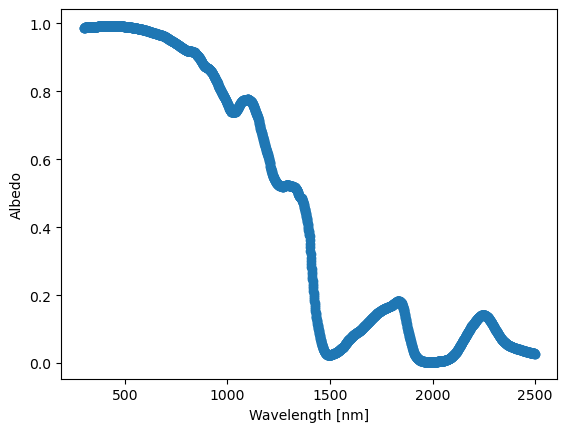

In [3]:
plt.scatter(wl, alb)
plt.ylabel('Albedo')
plt.xlabel('Wavelength [nm]')
plt.show()

# ALBEDO

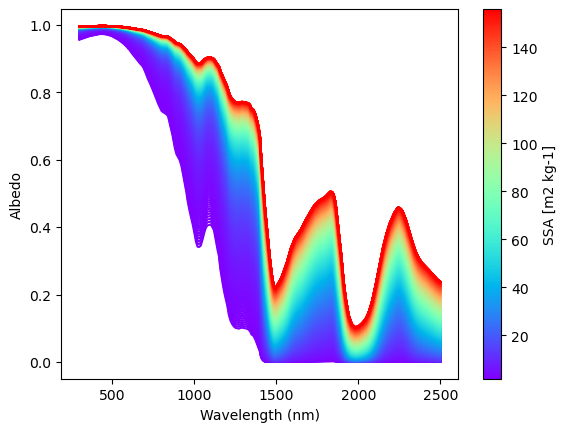

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(2, 156, 0.1)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=vals[i], c=0, lwc=0.1, cos_sza=0.5, cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, alb, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='SSA [m2 kg-1]')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Albedo')

plt.show()

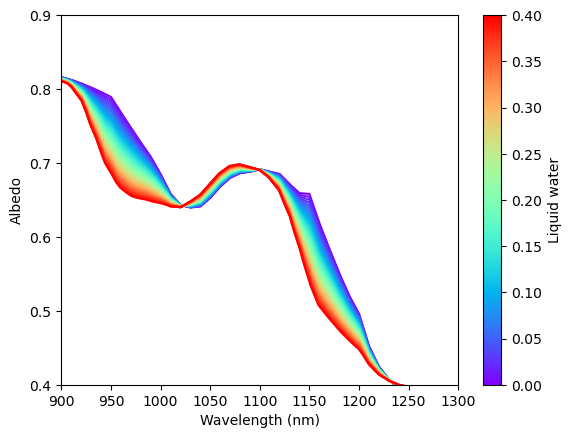

In [5]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(0, 0.40001, 0.01)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=vals[i], cos_sza=1, cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, alb, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='Liquid water')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Albedo')
plt.xlim(900,1300)
plt.ylim(0.4,0.9)
plt.show()

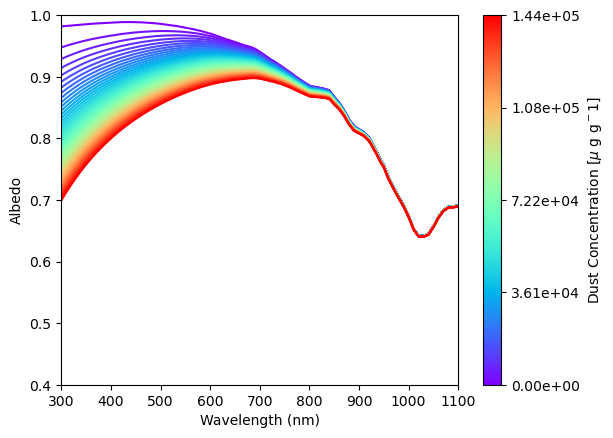

In [6]:
# Note.. Dust is assumed here with density 
# Dust, c is dust concentration (Caponi 2017) in units of microg / g. We assume MAE400=180 and aae=3.2
# I use a scale factor to convert to real units.scale_factor = (2.65 / 0.917) * 10e9


wl = np.arange(300, 2500, 1)
vals = np.arange(0, 0.5*1e-5, 1e-7)
n = len(vals)

scale_factor = (2.65 / 0.917) * 10e9
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(n):
    refl, alb = art(ssa=25, c=vals[i], lwc=0.1, cos_sza=1, cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    color = cmap(norm(vals[i]))  # Use the original normalization
    ax.plot(wl, alb, color=color)

cbar = plt.colorbar(sm, ax=ax)

# Update colorbar ticks and labels to reflect the scaled values
ticks = np.linspace(min(vals), max(vals), num=5)  # Create a set of ticks
scaled_ticks = ticks * scale_factor
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick * scale_factor:.2e}' for tick in ticks])
cbar.set_label(f'Dust Concentration [$\mu$ g g$^{-1}$]')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Albedo')
ax.set_xlim(300, 1100)
ax.set_ylim(0.4, 1)
plt.show()

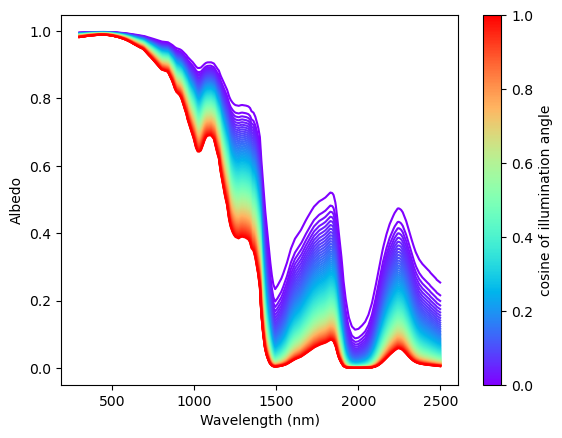

In [7]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(1e-16, 1.0001, 0.01)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=0.1, cos_sza=vals[i], cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, alb, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='cosine of illumination angle')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Albedo')
#plt.xlim(900,1300)
#plt.ylim(0.,1)
plt.show()

# REFLECTANCE

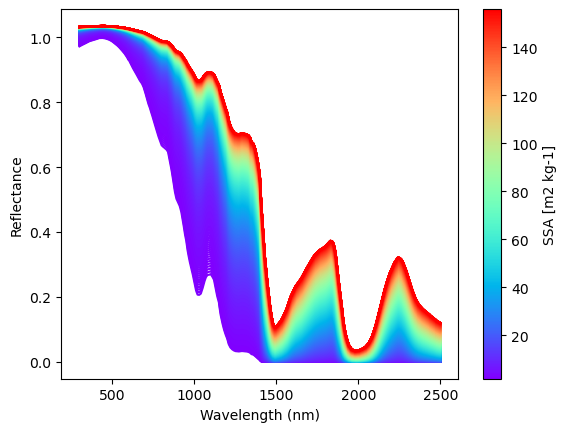

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(2, 156, 0.1)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=vals[i], c=0, lwc=0.1, cos_sza=0.75, cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, refl, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='SSA [m2 kg-1]')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')

plt.show()

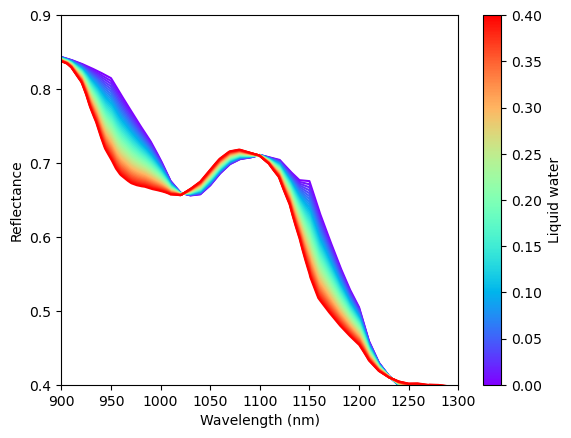

In [9]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(0, 0.40001, 0.01)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=vals[i], cos_sza=0.75, cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, refl, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='Liquid water')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
plt.xlim(900,1300)
plt.ylim(0.4,0.9)
plt.show()

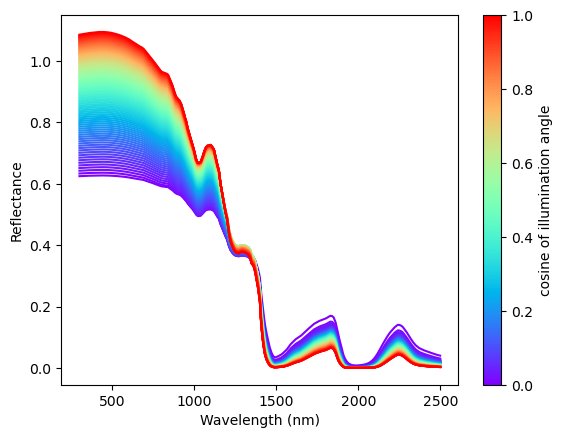

In [10]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(1e-16, 1.0001, 0.01)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=0.1, cos_sza=vals[i], cos_vza=1.0, theta=180, sensor_wavelengths=wl)
    ax.plot(wl, refl, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='cosine of illumination angle')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
#plt.xlim(900,1300)
#plt.ylim(0.,1)
plt.show()

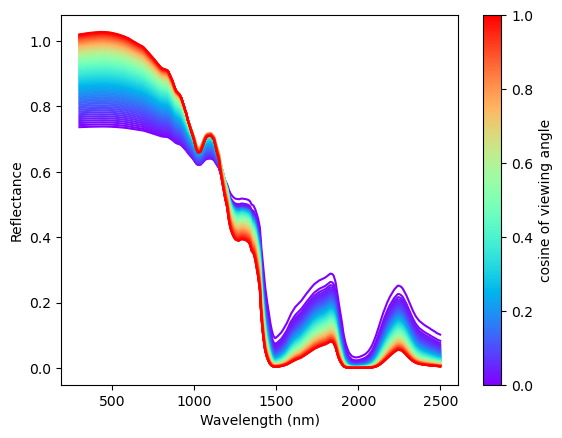

In [11]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(1e-16, 1.0001, 0.01)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=0.1, cos_sza=0.75, cos_vza=vals[i], theta=180, sensor_wavelengths=wl)
    ax.plot(wl, refl, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='cosine of viewing angle')

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
#plt.xlim(900,1300)
#plt.ylim(0.,1)
plt.show()

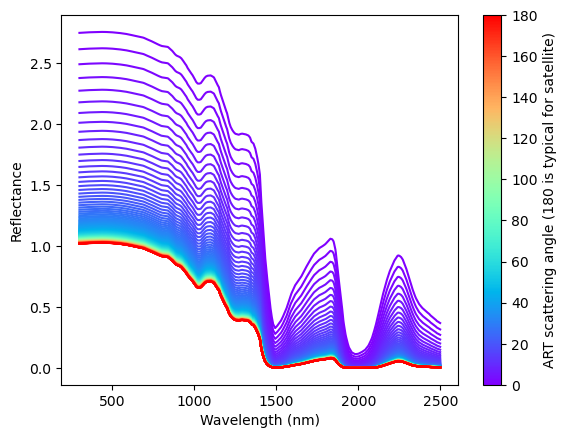

In [12]:
# Define wavelengths and SSA values
wl = np.arange(300, 2500, 1)
vals = np.arange(0,180.01,1)
n = len(vals)

# Create a colormap and normalize it to the range of SSA values
norm = mcolors.Normalize(vmin=min(vals), vmax=max(vals))
cmap = plt.cm.rainbow

# Create a figure and axis
fig, ax = plt.subplots()

# Create a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot each line with the corresponding color
for i in range(n):
    refl, alb = art(ssa=25, c=0, lwc=0.1, cos_sza=0.75, cos_vza=1.0, theta=vals[i], sensor_wavelengths=wl)
    ax.plot(wl, refl, color=cmap(norm(vals[i])))

# Add colorbar
cbar = plt.colorbar(sm, ax=ax, label='ART scattering angle (180 is typical for satellite)')
#  0 degrees ~ satellite looking into the sun and teh snow

# Set labels and title
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Reflectance')
#plt.xlim(900,1300)
#plt.ylim(0.,1)
plt.show()